# Prediction of aging parameters for partial data window

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
# parameter_values.search("Li")

In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [5]:
cell = 4

## Load eSOH Data and OCV Data

In [6]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

In [7]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [8]:
Temp

25

In [9]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        # "Positive electrode LAM constant proportional term [s-1]": 5*5e-3/3600,
        # "Negative electrode LAM constant proportional term [s-1]": 5*4.3e-2/3600,
        "Positive electrode LAM constant proportional term [s-1]": 1e-7,
        "Negative electrode LAM constant proportional term [s-1]": 1e-6,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
    },
    check_already_exists=False,
)


In [10]:
# all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment,SOC_0, save_at_cycles=1)

In [11]:
# fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [12]:
# fgdfdfg

# Parameter Fitting

## List of Initial Conditions

In [13]:
ic = 1
blam_p = [1e-6,1e-7,1/5*8e-7]
blam_n = [1e-5,1e-6,1/2*5.5e-6]
k_sei= [1*2e-16,1/5*2e-16,5*2e-16]

In [14]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Capacity [A.h]"])

def multi_objective(model, data):
    variables = ["C_n","C_p","x_100","y_0"]
    # variables = ["Capacity [A.h]", "C_n"]
    weights = [1,1,5,5]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )

def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment):
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "Positive electrode LAM constant exponential term": x[2]*2,
            "Negative electrode LAM constant exponential term": x[2]*2,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
        },
        check_already_exists=False,
    )
    return cycle_adaptive_simulation(spm, parameter_values, experiment, SOC_0,save_at_cycles=1)
def prediction_error(x):
    try:
        out=[]
        for cell in [1,4]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
            # print(f"Cell: {cell_no}")
            experiment = pybamm.Experiment(
                [
                    ("Discharge at "+c_rate_d+dis_set,
                    "Rest for 5 min",
                    "Charge at "+c_rate_c+" until 4.2V", 
                    "Hold at 4.2V until C/50")
                ] *dfe.N.iloc[-1],
                termination="50% capacity",
            #     cccv_handling="ode",
            )
            # print(f"Model")
            model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment)
            # print(f"Objective")
            out_t =   multi_objective(pd.DataFrame(model), dfe)
            # print(f"Concat")
            out=np.concatenate([out,out_t])
        print(f"x={x}, norm={np.linalg.norm(out)}")
    # except pybamm.SolverError:
    except:
        out=[]
        for cell in [1,4]:
            cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
            # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
            out_t = np.concatenate([np.array(dfe['Cap'])]*4)
            out=np.concatenate([out, out_t])
        out = 2*np.ones_like(out)
        print(f"Error")
        print(f"x={x}, norm={np.linalg.norm(out)}")
    return out

def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.0,1.0,1.0])
    # print(prediction_error(x0))
    lower = np.array([1e-3, 1e-3, 0.5])
    upper = np.array([1e+3, 1e+3, 2])
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2)
    print(timer.time())
    return soln_dfols
def sim_train(df):
    soln_dfols = train_model()
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    df['x_2'][0]=round(xsol[2],4)*2
    # df['obj'][0]=soln_dfols.f
    return xsol,df

In [15]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','obj'], index=[0])

In [16]:
# sim_des = "cell_"+cell_no
timer1 = pybamm.Timer()
train_len = len(N)
# for ic in range(0,3):
print("Initial Condition = {0}".format(ic))
x,df_x = sim_train(df_x)
# df_x.to_csv(res_DIR + "fit_train_betam_"+sim_des+'_ic'+str(ic)+".csv", index=False)
print(timer1.time())

Initial Condition = 1
x=[1. 1. 1.], norm=4.508214744749039
x=[1.1 1.  1. ], norm=4.508682995926125
x=[1.  1.1 1. ], norm=4.484985147479926
x=[1.  1.  1.1], norm=4.585696600425449
x=[0.99943719 1.12882876 0.90424727], norm=4.345600190342422
x=[0.99766341 1.39699738 0.6074604 ], norm=2.6909529577247473
x=[2.52004824 1.87741041 0.5       ], norm=2.4668963825036485
x=[0.9215074  1.80909374 0.5       ], norm=2.4373902097817464
x=[1.07494596 1.84475496 0.52801579], norm=1.8649954152164199
x=[1.46362473 2.16939603 0.5       ], norm=3.318980801008675
x=[1.06604664 1.86404495 0.62807895], norm=2.326873937488959
x=[1.27277777 2.18396566 0.60416479], norm=1.7592615784870158
x=[1.65735606 2.28734025 0.56657177], norm=1.7110968308644432
x=[2.03925223 2.40029157 0.60395248], norm=1.6236903991905836
x=[2.5719224  2.49668261 0.59939875], norm=1.5907186769916775
x=[2.5691606  2.51063759 0.76221173], norm=3.084268048329755
x=[2.34923413 2.26855432 0.57169643], norm=1.629372784233961
x=[2.66670748 2.4029

In [17]:
sim_des="cell_1_4"
df_x.to_csv(res_DIR + "cycl_train_"+sim_des+".csv")

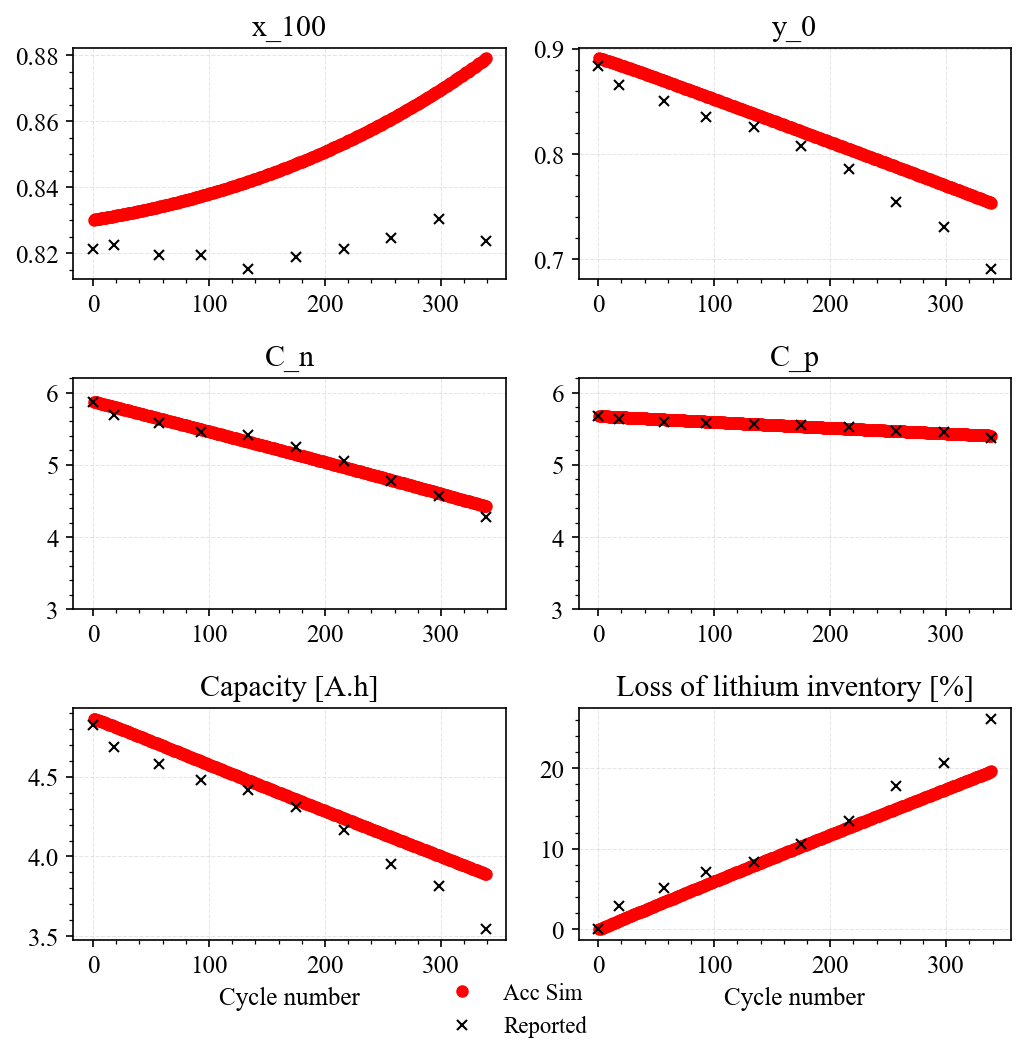

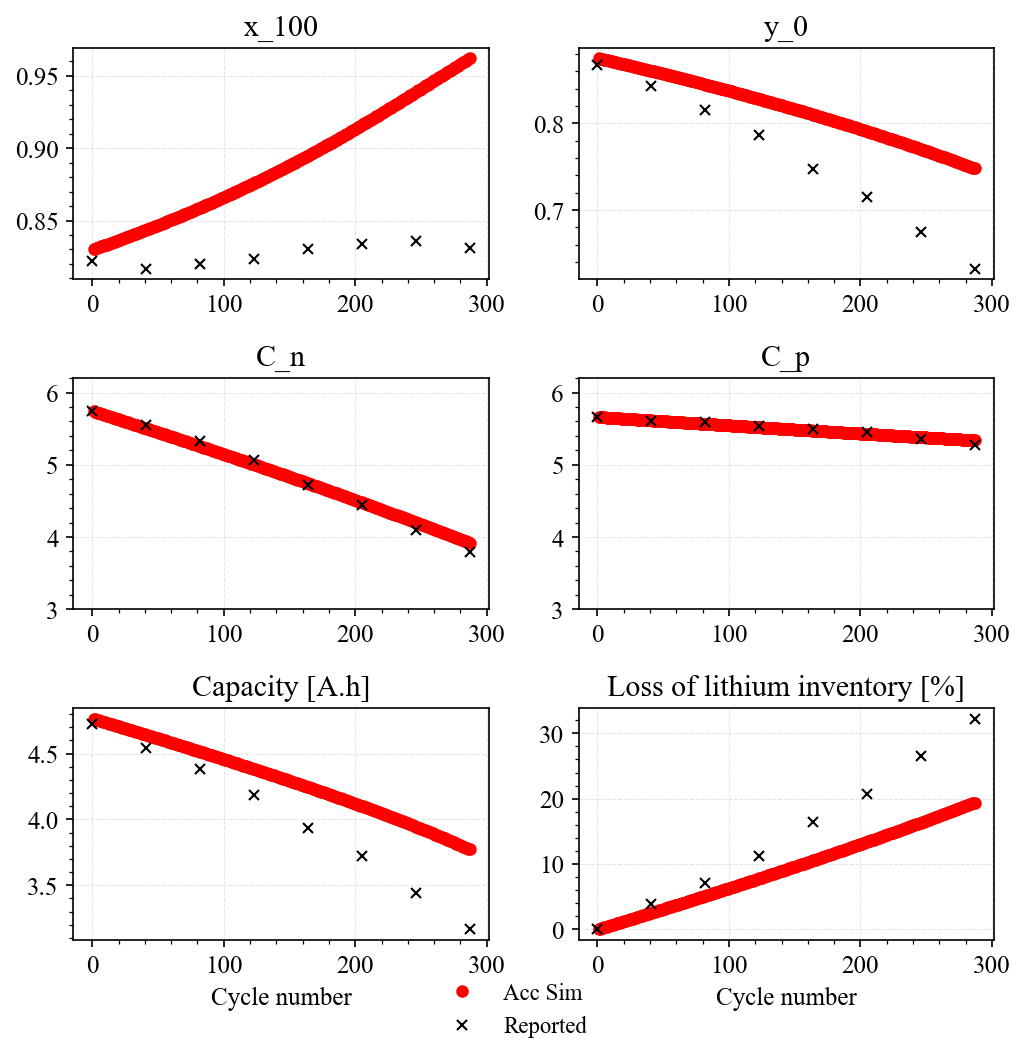

In [18]:
for cell in [1,4]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    experiment = pybamm.Experiment(
        [
            ("Discharge at "+c_rate_d+dis_set,
            "Rest for 5 min",
            "Charge at "+c_rate_c+" until 4.2V", 
            "Hold at 4.2V until C/50")
        ] *dfe.N.iloc[-1],
        termination="50% capacity",
    #     cccv_handling="ode",
    )
    # print(f"Model")
    sol_out = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment)
    fig = plotc(sol_out,dfe);
    plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_tuning_out.png')

In [20]:
x

array([2.51116961, 2.47410322, 0.59710901])